# Load

## Tarefas:

* Padronizar os dados de todos os 4 participantes dos dados single-target e salvar de forma adequada para utilização nos próximos notebooks.
* Realizar o mesmo estudo para os dados multi-target

In [58]:


# imports

from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder
import numpy as np
import mne
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
import warnings
from copy import deepcopy

# Importação de bibliotecas necessárias
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

## Beta: 

### Carregamento

#### Fields:

![Alt text](image.png)

In [59]:
# pré-carregamento
data = loadmat(f"../../datasets/beta/S10.mat")['data'][0][0]

eeg_data = data[0]
print(eeg_data.shape)

(64, 750, 4, 40)


### Load Data

In [60]:
# extração direta dos dados
print("Divisão dos dados:")

eeg = eeg_data.reshape(eeg_data.shape[0], eeg_data.shape[1], eeg_data.shape[2] * eeg_data.shape[3])
labels = np.array(list(data[1]['freqs'][0][0].flatten()) * 4)

print(labels)
print(eeg.shape, labels.shape)

Divisão dos dados:


[ 8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2
 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.
 14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4  8.6  8.8
  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6
 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.  14.2 14.4
 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4  8.6  8.8  9.   9.2
  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.
 12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8
 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6
  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4
 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2
 15.4 15.6 15.8  8.   8.2  8.4]
(64, 750, 160) (160,)


### Criando MNE

In [61]:
# criação de um objeto "info"
n_channels = 64
sfreq = data[1]['srate'][0][0][0][0]
ch_names = [data[1]['chan'][0][0][index][3][0] for index in range(64)]
ch_types = ['eeg'] * 64
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
>

In [62]:
data_correct = eeg.swapaxes(0, 2)
data_correct = data_correct.swapaxes(1, 2)
print(data_correct.shape)

# método para transformar labels categóricos
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(len(labels), dtype=int),
    LabelEncoder().fit_transform(labels))
)

event_dict = {'8.6': 3, '8.8': 4, '9.0': 5, '9.2': 6, '9.4': 7, '9.6': 8, '9.8': 9, '10.0': 10, '10.2': 11, '10.4': 12, '10.6': 13, '10.8': 14, '11.0': 15, '11.2': 16, '11.4': 17, '11.6': 18, '11.8': 19, '12.0': 20, '12.2': 21, '12.4': 22, '12.6': 23, '12.8': 24, '13.0': 25, '13.2': 26, '13.4': 27, '13.6': 28, '13.8': 29, '14.0': 30, '14.2': 31, '14.4': 32, '14.6': 33, '14.8': 34, '15.0': 35, '15.2': 36, '15.4': 37, '15.6': 38, '15.8': 39, '8.0': 0, '8.2': 1, '8.4': 2}

mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
print(mne_data)

(160, 64, 750)
Not setting metadata
160 matching events found


No baseline correction applied
0 projection items activated
<EpochsArray |  160 events (all good), 0 – 2.996 s, baseline off, ~58.7 MB, data loaded,
 '8.6': 4
 '8.8': 4
 '9.0': 4
 '9.2': 4
 '9.4': 4
 '9.6': 4
 '9.8': 4
 '10.0': 4
 '10.2': 4
 '10.4': 4
 and 30 more events ...>


## Visualização

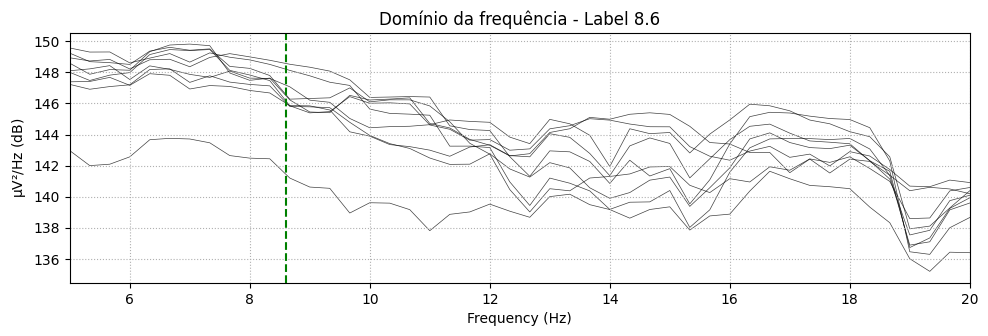

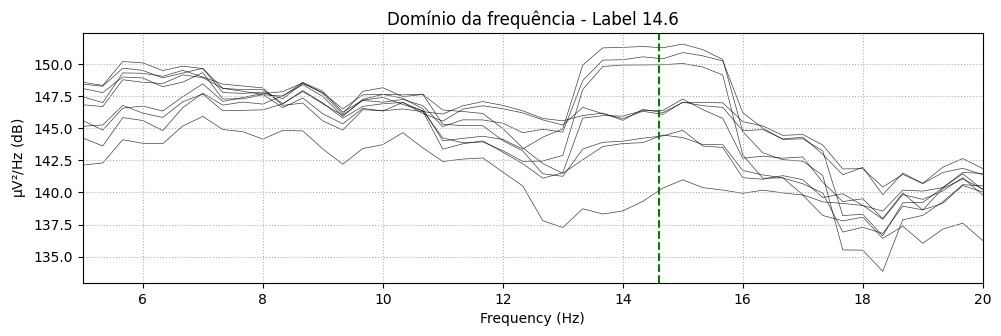

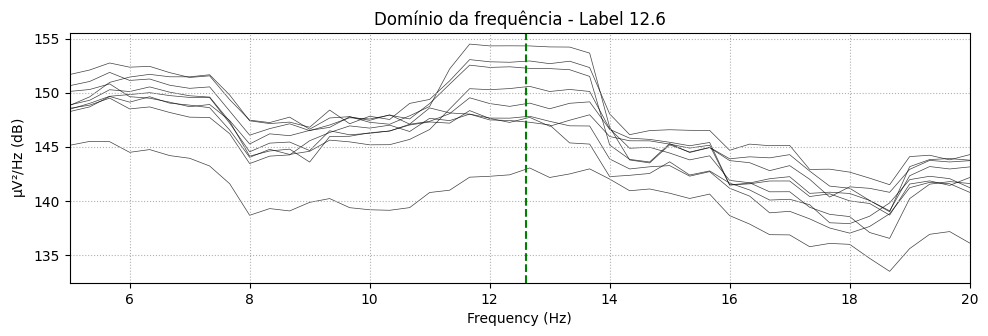

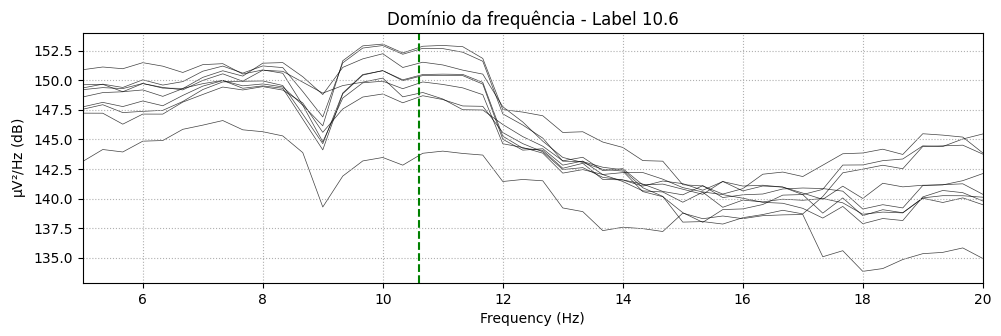

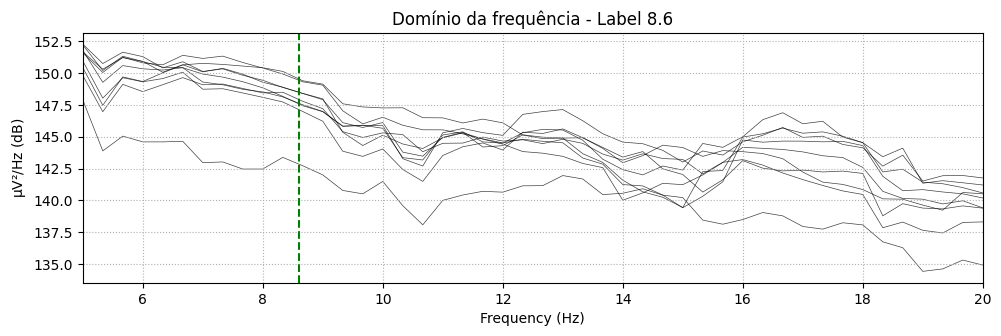

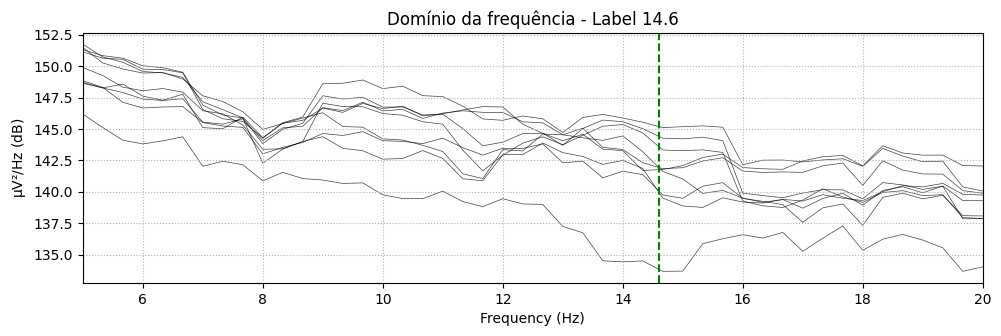

In [63]:
warnings.filterwarnings('ignore')

mne_data_plot = deepcopy(mne_data)
mne_data_plot = mne_data_plot.drop_channels([name for name in ch_names if name not in ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']])

for i in range(0, len(mne_data), 30):
    view = mne_data_plot[i].compute_psd(method='multitaper', fmin=5, fmax=20, verbose=False)
    view.plot(show=False)
    plt.title(f'Domínio da frequência - Label {labels[i]:.1f}')
    plt.axvline(x=float(list(mne_data_plot[i].event_id)[0]), linestyle='--', color='green')
    plt.show()

## Classificação

### Classificação por frequência mais alta.

In [64]:
threshold = 0.2
freqs = data[1]['freqs'][0][0].flatten()

y_pred = []

for i in range(len(mne_data_plot)):
    psd = mne_data_plot[i].compute_psd(method='welch', fmin=7.9, fmax=15.9, verbose=False)
    targets = [psd.get_data(fmin=f-threshold, fmax=f+threshold).mean() for f in freqs]
    y_pred.append( freqs[np.argmax(targets)] )
    
#calcular acuracia
print('Acurácia:', sum(y_pred == labels) / len(labels))

Acurácia: 0.30625


#### Comparando as labels com a predição:

In [65]:
accy = 0
for i in range(len(labels)):
    print(labels[i], y_pred[i])
    
    if labels[i] == y_pred[i]:
        accy += 1/len(labels)

print(accy)

8.6 8.6
8.799999999999999 9.0
9.0 8.0
9.2 12.4
9.4 12.0
9.6 10.0
9.8 9.6
10.0 11.4
10.2 10.4
10.4 8.6
10.6 15.600000000000001
10.8 11.6
11.0 11.0
11.2 9.0
11.4 8.4
11.6 8.6
11.8 11.4
12.0 12.0
12.2 12.0
12.4 12.4
12.600000000000001 12.600000000000001
12.8 12.600000000000001
13.0 13.0
13.200000000000001 13.0
13.4 13.200000000000001
13.600000000000001 13.200000000000001
13.8 13.600000000000001
14.0 15.600000000000001
14.200000000000001 14.0
14.4 14.200000000000001
14.600000000000001 14.600000000000001
14.8 14.600000000000001
15.0 15.0
15.200000000000001 15.200000000000001
15.4 15.200000000000001
15.600000000000001 15.600000000000001
15.8 15.600000000000001
8.0 8.6
8.2 10.6
8.4 10.6
8.6 8.4
8.799999999999999 9.6
9.0 8.0
9.2 11.6
9.4 9.4
9.6 8.6
9.8 9.6
10.0 8.0
10.2 10.0
10.4 10.4
10.6 10.6
10.8 10.6
11.0 9.6
11.2 11.4
11.4 10.4
11.6 11.6
11.8 11.6
12.0 12.0
12.2 12.4
12.4 12.4
12.600000000000001 12.600000000000001
12.8 8.0
13.0 13.0
13.200000000000001 13.200000000000001
13.4 13.200000000

### Classificação por SVM.

#### Ruído de fundo

In [66]:
signal_data = deepcopy(data_correct)
print(signal_data.shape)

no_stimulus_start_1 = 0
no_stimulus_end_1 = 125
no_stimulus_start_2 = 625
no_stimulus_end_2 = 750

background_noise_estimates = []

for single_trial in signal_data: 
    individual_electrode_noise = [] 

    for electrode_signal in single_trial:
        power_spectral_density = np.abs(np.fft.fft(electrode_signal)) ** 2

        power_no_stimulus_1 = np.mean(power_spectral_density[no_stimulus_start_1:no_stimulus_end_1])
        power_no_stimulus_2 = np.mean(power_spectral_density[no_stimulus_start_2:no_stimulus_end_2])
        average_noise_power = (power_no_stimulus_1 + power_no_stimulus_2) / 2

        individual_electrode_noise.append(average_noise_power)

    background_noise_estimates.append(np.mean(individual_electrode_noise))

final_noise_array = np.array(background_noise_estimates)

print(final_noise_array.shape)

(160, 64, 750)
(160,)


### Amplitudes

In [67]:
sampling_frequency = sfreq

target_frequencies = np.arange(8, 16, 0.2)
all_trials_amplitudes = []

for single_trial in signal_data: 
    amplitudes_per_electrode = []

    for electrode_signal in single_trial:
        fft_result = np.fft.fft(electrode_signal)
        power_spectral_density = np.abs(fft_result) ** 2
        frequencies = np.fft.fftfreq(len(fft_result), 1 / sampling_frequency)

        electrode_target_amplitudes = []
        for target_frequency in target_frequencies:
            frequency_index = np.argmin(np.abs(frequencies - target_frequency))
            amplitude_at_target = np.sqrt(power_spectral_density[frequency_index])
            electrode_target_amplitudes.append(amplitude_at_target)

        amplitudes_per_electrode.append(electrode_target_amplitudes)
    
    all_trials_amplitudes.append(amplitudes_per_electrode)

final_amplitude_array = np.array(all_trials_amplitudes)
print(final_amplitude_array.shape)


(160, 64, 40)


### SNR

In [68]:
def calculate_narrow_band_SNR(amplitude_values, background_noise_values):
    adjusted_amplitudes = np.abs(amplitude_values - background_noise_values)
    snr_values = 10 * np.log10(adjusted_amplitudes / background_noise_values)
    return snr_values

def calculate_wide_band_SNR(amplitude_values, background_noise_values):
    adjusted_amplitudes = np.abs(amplitude_values - background_noise_values)
    total_power = np.sum(adjusted_amplitudes)
    snr_values = 10 * np.log10(adjusted_amplitudes / total_power)
    return snr_values

def calculate_adjusted_amplitudes(amplitude_values, background_noise_values):
    return np.abs(amplitude_values - background_noise_values)

def calculate_mean_freqs(data, threshold):
  psd = data.compute_psd(method='welch', fmin=7.9, fmax=15.9, verbose=False)
  data = np.array([psd.get_data(fmin=f-threshold, fmax=f+threshold).mean(axis=-1) for f in freqs])
  return data.reshape(data.shape[0] * data.shape[1], data.shape[2]).swapaxes(0,1)

In [69]:
# signal_data = deepcopy(mne_data)

# def calculate_mean_freqs(data, threshold):
#   psd = data.compute_psd(method='welch', fmin=7.9, fmax=15.9, verbose=False)
#   data = np.array([psd.get_data(fmin=f-threshold, fmax=f+threshold).mean(axis=-1) for f in freqs])
#   return data.reshape(data.shape[0] * data.shape[1], data.shape[2]).swapaxes(0,1)

# calculate_mean_freqs(signal_data[0], 0.2).shape
# # signal_data[0]

Criação do vertor de características

In [70]:
signal_data = deepcopy(mne_data)

# Inicializando a lista de características e definindo os rótulos
feature_list = []
labels = labels

# Iterando sobre cada ensaio no conjunto de dados
for i in range(len(signal_data)):
    # Calculando a SNR em banda estreita e banda larga para o ensaio atual
    snr_narrow_band = calculate_narrow_band_SNR(final_amplitude_array[i], final_noise_array[i])
    snr_wide_band = calculate_wide_band_SNR(final_amplitude_array[i], final_noise_array[i])
    adjusted_amplitudes = calculate_adjusted_amplitudes(final_amplitude_array[i], final_noise_array[i])
    media = np.array(calculate_mean_freqs(signal_data[i], 0.2))
    # print(snr_narrow_band.shape, snr_wide_band.shape, adjusted_amplitudes.shape, media.shape)
    
    # Adicionando os resultados à lista de características
    feature_list.append([snr_narrow_band, snr_wide_band, adjusted_amplitudes, media])

# Convertendo a lista de características em um array NumPy
feature_array = np.array(feature_list)

# Reorganizando as dimensões do array
feature_array = feature_array.swapaxes(1, 2)

# Redimensionando o array para combinar as duas últimas dimensões
feature_array = feature_array.reshape(feature_array.shape[0], feature_array.shape[1], feature_array.shape[2] * feature_array.shape[3])

# Imprimindo a forma final do array de características
print(feature_array.shape)



(160, 64, 160)


Remoção das características de maneira manual:

In [71]:
# Esses índices correspondem aos canais: ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']
from sklearn.pipeline import Pipeline


selected_channels = [47, 53, 54, 55, 56, 57, 60, 61, 62]

arrayManual = deepcopy(feature_array)
arrayManual = np.array(arrayManual)
print(arrayManual.shape)

# Mantemos apenas os canais selecionados
arrayManual = arrayManual[:, selected_channels, :]

# Redimensionamos os dados para ter uma dimensão de características. 
arrayManual = arrayManual.reshape(arrayManual.shape[0], arrayManual.shape[1]*arrayManual.shape[2])
print(arrayManual.shape)

# StandardScaler é usado para normalizar o conjunto de dados, garantindo que tenha média 0 e variância 1.
arrayManual = StandardScaler().fit_transform(arrayManual)

# Codificamos as labels 'y' em valores numéricos.
ym = LabelEncoder().fit_transform(labels)

# Dividimos o conjunto de dados em conjuntos de treinamento e teste.
x_train, x_test, y_train, y_test = train_test_split(arrayManual, ym, test_size=0.25, random_state=42)


param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf', 'poly']},
 ]
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, cv=2)
grid.fit(x_train, y_train)
y_pred = grid.predict(x_test)


# Calculando acurácia
print('Acurácia:', accuracy_score(y_test, y_pred))

(160, 64, 160)
(160, 1440)
Acurácia: 0.175


Remoção das características de maniera automática:

In [72]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn import svm

arrayAuto = deepcopy(feature_array)
arrayAuto = np.array(arrayAuto)

# Redimensionamos os dados para ter uma dimensão de características. 
arrayAuto = arrayAuto.reshape(arrayAuto.shape[0], arrayAuto.shape[1]*arrayAuto.shape[2])

# Normalizamos os dados para ter média 0 e variância 1.
arrayAuto = StandardScaler().fit_transform(arrayAuto)

# Codificamos as labels 'y' em valores numéricos.
ya = LabelEncoder().fit_transform(labels)
print(arrayAuto.shape, ya.shape)

# RFE (Recursive Feature Elimination with Cross-Validation):
rfe = RFECV(svm.SVC(kernel="linear"), step=0.0001, min_features_to_select=1000, cv=2)
# rfe = RFE(svm.SVC(kernel="linear"), step=0.0001, n_features_to_select=1000)
X_final = rfe.fit_transform(arrayAuto, ya)
print(X_final.shape)

# Dividimos o conjunto de dados em conjuntos de treinamento e teste.
x_train, x_test, y_train, y_test = train_test_split(X_final, ya, test_size=0.25)

parameters = {'kernel':['linear'], 'C':[1, 10, 100, 1000]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=2)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# Calculando acurácia
print('Acurácia:', accuracy_score(y_test, y_pred))


(160, 10240) (160,)


KeyboardInterrupt: 